### 1.Summary

<font size=3>Face modelling serves as one of the most fundamental problems in modern artifical intelligence and computer vision, and can be useful in various applications like face recognition, identification etc. However, face images are usually of high-dimensional (e.g., a small 100 X 100 gray-scaled face image has dimension 100 X 100 = 10,000), therefore, find a suitable representation is utterly important. In this problem, we apply the linear model, principal component analysis (PCA), on face images to reduce the dimension and obtain eigenface representations.</font>

Dataset: we use the datasety which contains 177 face images. Each image contains 256X256
pixels and is gray-scaled (i.e., the value for each pixel is stored as unsigned integer between [0; 255],
typically, 0 is taken to be black and 255 is taken to be white). You need to split the dataset to be
train/test set, e.g., you could use the first 157 images for training, and the rest 20 faces for testing.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import sys
#np.set_printoptions(threshold=sys.maxsize)
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=100)
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_lfw_people
from sklearn import datasets

from IPython.display import display
from PIL import Image
from PIL import ImageTk
import glob

In [16]:
"""
path = '03_data/face_data'

test_1 = os.listdir(path)[1:177]

images = [path+'/' + photo for photo in test_1]

images_data = np.array([plt.imread(image) for image in images], dtype=np.float64)


images_data[1].shape
"""

### READ MODEL

In [264]:
#we use this model to read face data and display
#it will be used to read train and test data
def read_image_display(path,num_images,size):
    #face_array will resotre the image in vector type and display_face restore the real *.bmp images
    face_array = []
    display_face = []
    #path = '03_data/face_data/*.bmp'
    for face_images in glob.glob(path):
        #open face by order
        face_image = Image.open(face_images)
        display_face.append(face_image)
        #original grey 
        face_image = np.asarray(face_image, dtype=float)/255.0
        face_array.append(face_image)
    display_single(display_face,num_images,size)
    #print(display_face[0:5])
    return face_array

<br>

### DISPLAY MODEL

In [265]:
#show top 10 face
def display_single(images,n,size):
    fig2, axes_array = plt.subplots(1,n)
    fig2.set_size_inches(size,size)
    count = 0
    for x in range(n):
        draw_image = images[count]
        image_plot = axes_array[x].imshow(draw_image, cmap=plt.cm.gray)
        axes_array[x].axis("off")
        count+=1
    fig2.canvas.set_window_title("Eigen Faces")
    plt.show()

In [266]:
#input will be a list with images 
def display_face_grid(display_face):
    size=30,30
    fig1, axes_array = plt.subplots(5,5)
    fig1.set_size_inches(5,5)
    count = 0
    for x in range(5):
        for y in range(5):
            draw_image = display_face[count]
            draw_image.thumbnail(size)
            draw_image=np.asarray(draw_image, dtype=float)/255.0
            image_plot = axes_array[x][y].imshow(draw_image, cmap=plt.cm.gray)
            axes_array[x][y].axis('off')
            count +=1
    fig1.canvas.set_window_title('Displaying all faces')
    plt.show()

<br>

### CALCUALTION MODEL

In [267]:
#thi mod is uesd to calculate mean face to 
def mean_face(face_array):
    mean = np.mean(face_array,0)
    fig3, axes_array = plt.subplots(1,1)
    fig3.set_size_inches(5,5)
    image_plot = axes_array.imshow(mean, cmap=plt.cm.gray)
    fig3.canvas.set_window_title("mean faces")
    plt.show()
    return mean

In [268]:
#use 
def pca(face_array):
    print("Mean Face Display")
    mean = mean_face(face_array)
    
    #flattening array
    flatten_array = []
    for num in range(len(face_array)):
        #chagne 256x256 bmp vector to 1x65536
        flat_1 = face_array[num].flatten()
        #final pca maxtrix will be 157X65536, first row depend on train(157) or test(20)
        flatten_array.append(flat_1)
    flatten_array = np.asarray(flatten_array)
    print("SHAPE of flatten_array", flatten_array.shape)
    mean = mean.flatten()
    subtract_mean = np.subtract(flatten_array, mean)
    return mean, flatten_array, subtract_mean

In [273]:
def eigenface(face_array,n_pc):
    n_samples, n_1, n_2 = np.array(face_array).shape
    mean, flatten_array,subtract_mean = pca(face_array)
    #sometimes we use centered_data to represent subtract_mean
    subtract_mean = np.subtract(flatten_array, mean)
    #u is mxk, s is sigma kxk , v is kxn
    u, s, v =np.linalg.svd(subtract_mean, full_matrices=False)
    #print(u.shape)
    #print(s.shape)
    #print(v.shape)
    components_face = v[:n_pc]
    #print(components_face.shape)
    projected = u[:,:n_pc] * s[:n_pc]
    #print(projected.shape)
    #print(subtract_mean.shape)
    eigen_face =[]
    for y in range(v.shape[0]):
        fig = np.reshape(v[y],(256,256))
        eigen_face.append(fig)
    print("eigen face", display_single(eigen_face,10,5))
    return eigen_face, mean, subtract_mean, projected, components_face, u, s, v, 

In [293]:
def reconstruct(mean, subtract_mean, k, V, num, size):
    weights = np.dot(subtract_mean, V.T)
    recon = mean.flatten() + np.dot(weights[:,0:k], V[0:k,:])
    fig4, axes = plt.subplots(1,num)
    fig4.set_size_inches(size,size)
    count = 0
    
    recon_face=[]
    for x in range(num):
        draw_image = np.reshape(recon[count,:],(256,256))
        imapge_plot = axes[x].imshow(draw_image, cmap=plt.cm.gray)
        axes[x].axis('off')
        count+=1
        recon_face.append(draw_image)
    fig4.canvas.set_window_title("Reconstruct faces for k="+str(k))
    plt.show()
    return recon_face

In [305]:
def recon_error(recon_face, test_face, number_set):
    error_set = []
    for x in range(number_set):
        norm = np.linalg.norm(recon_face[x] - test_face[x],ord=2)
        error = norm*norm/number_set
        error_set.append(error)
    return error_set

<br>

### MAIN FUNCTION

### (1)Write the PCA codes to compute K=30 eignfaces and visulaize the top 10 eigenfaces

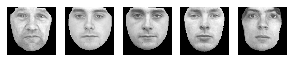

Mean Face Display


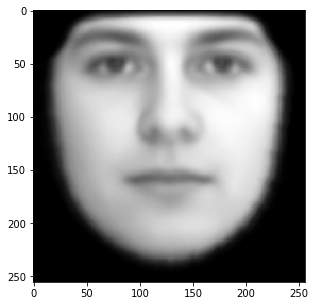

SHAPE of flatten_array (157, 65536)


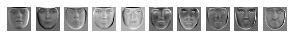

eigen face None


Mean Face Display


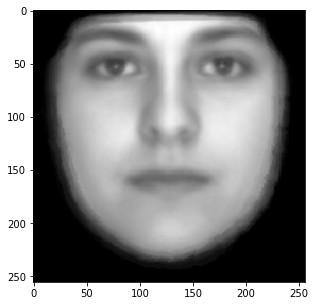

SHAPE of flatten_array (20, 65536)


In [312]:
if __name__=="__main__":
    #face_array = read_image_display()
    train_path='03_data/10_face_data_train/*.bmp'
    train_face_array = read_image_display(train_path,5,5)
    train_eigenface, mean, subtract_mean, projected, componnent, U, S, V,  = eigenface(train_face_array, 30)
    #print(U)
    
    test_path='03_data/11_face_data_test/*.bmp'
    test_face_array = read_image_display(test_path,20,5)
    test_mean, test_flatten_array, test_subtract_mean = pca(test_face_array)

### (2) [20pt] Use the learned K eigenfaces from (1) to reconstruct testing images, and recordthe reconstruction error. The reconstruction error can be dened as jj ^ Y 􀀀Y jj2N , where ^ Y is thereconstructed face using the learned eigenfaces, Y is the testing faces and N is the total number oftesting data. Please show 5 testing images and their reconstructed ones.

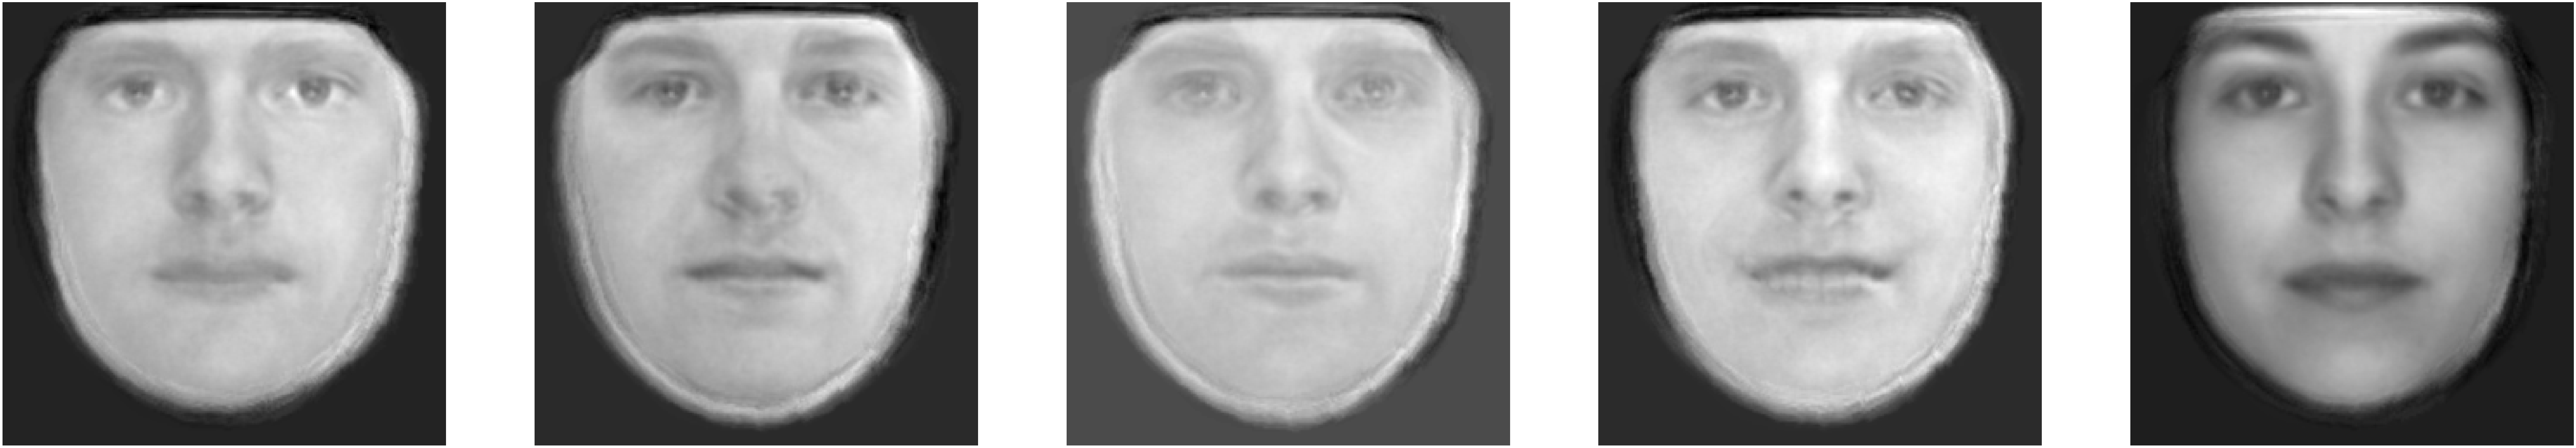

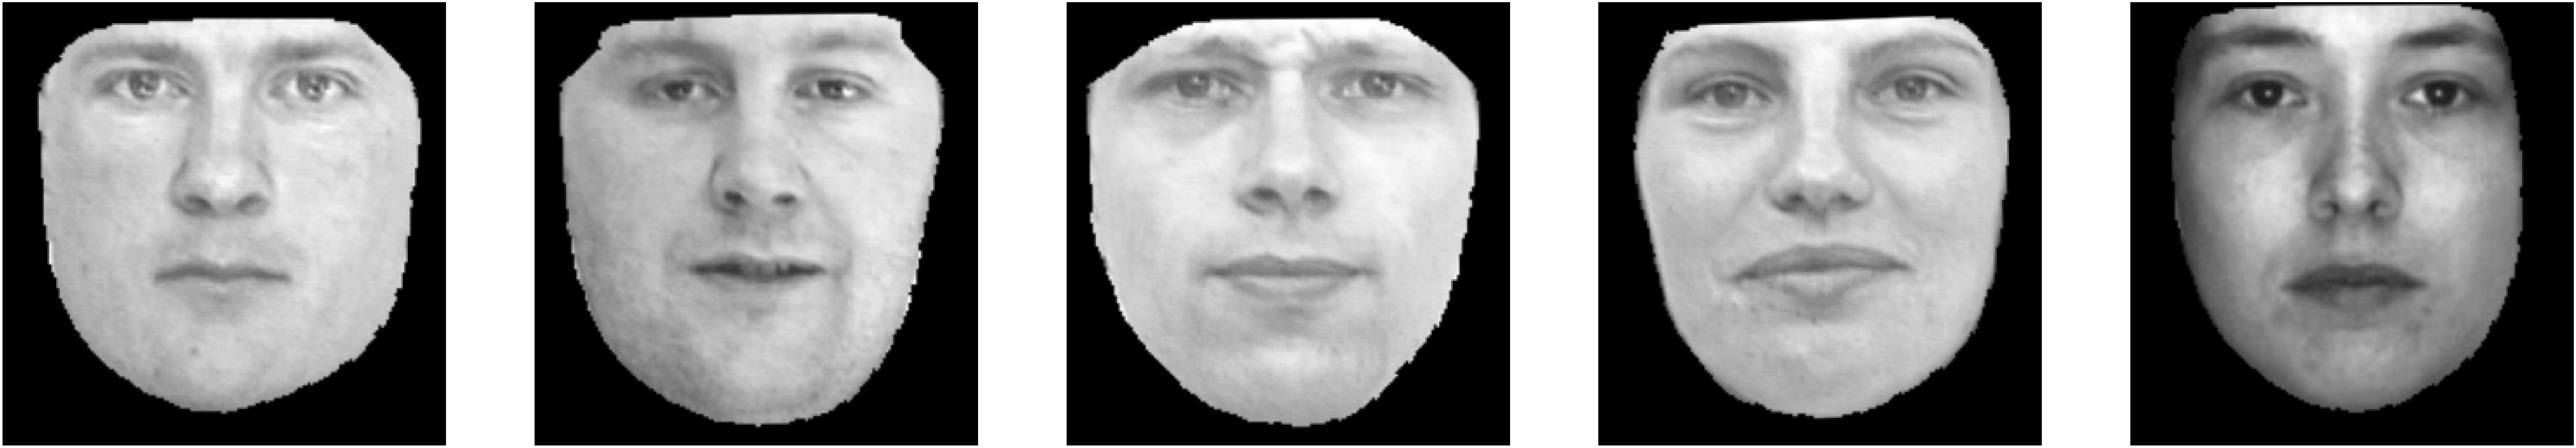

'\n\ntest_eigenface = eigenface(test_face_array)\n    '

In [313]:

#compenent is the first 30rows V in SVD
k=30
recon_face = reconstruct(test_mean, test_subtract_mean, k, componnent,5,128)
test_face_array = read_image_display(test_path,5,128)
"""

test_eigenface = eigenface(test_face_array)
    """

In [249]:
len(recon_face)

20

### (3) [20pt] Try dierent values of K, e.g., try K = 10; 30; 50; 100; 150:::, and draw the curve toindicate the corresponding testing reconstruction errors. The x-axis of the c

[[2.665981480377167, 2.8098230763271927, 3.2991040214617255, 4.080874560540602, 2.257880854697108, 2.603495134860741, 2.552134651673165, 2.861757605903703, 3.2187714234714475, 3.4068242716918355, 5.045366775814193, 3.72417048786881, 2.4340327928824452, 4.2668938185672785, 2.854403667688355, 3.3025919761999027, 2.336513741747575, 2.6637170850172693, 2.532862229942909, 3.272929526605032], [0.9004145700171196, 1.9026374742057008, 2.0589002016632794, 1.7980600969225722, 1.6398522120715324, 1.6958298382932238, 1.3548224200382166, 1.2707552789491259, 1.6259409143860406, 1.9621799221834668, 2.710951296501997, 2.056008211079578, 1.964087807085066, 2.6727924536478787, 1.427844028734876, 2.8471598524246273, 1.3937806709346812, 1.541704382662391, 1.6744604552583138, 1.9887782639012896], [0.9004145700171196, 1.9026374742057008, 2.0589002016632794, 1.7980600969225722, 1.6398522120715324, 1.6958298382932238, 1.3548224200382166, 1.2707552789491259, 1.6259409143860406, 1.9621799221834668, 2.7109512965

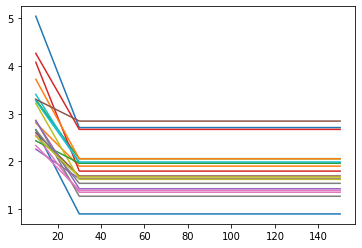

In [311]:
k=[10,30,50,100,150]
error_curve=[]
for i in k:
    recon_face = reconstruct(test_mean, test_subtract_mean, i, componnent,20,5)
    error_set = recon_error(recon_face, test_face_array, 20)
    error_curve.append(error_set)
print(error_curve)    
plt.plot(k,error_curve)
plt.show()

In [298]:
len(test_face_array)

20

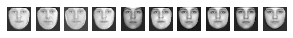

In [295]:
recon_face = reconstruct(test_mean, test_subtract_mean, 10, componnent,10,5)


In [296]:
len(recon_face)

10

In [302]:
recon_face[0]

array([[5.69581387e-15, 6.47975787e-15, 3.82549178e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [256]:
print(error_set)

[7.797501032018127, 7.960575477312233, 7.906481749489974, 7.178449175117301, 3.2094657551010584, 6.995359671298115, 4.4037466374831435, 6.6838304178273376, 7.220837610654256, 7.09693129734314, 8.5838100281856, 7.986457080207839, 2.9130839156696067, 5.404549239411319, 5.391860345494189, 9.79869101177542, 4.486042527146781, 7.682630598780854, 7.410418293318853, 3.7060311654897147]


In [181]:
np.array(train_face_array).shape

(157, 256, 256)

In [141]:
print(U.shape)

(157, 157)


In [192]:
mean = np.mean(train_face_array,0)

In [193]:
mean.shape

(256, 256)

In [151]:
V.shape

(157, 65536)

In [150]:
subtract_mean.shape

(157, 65536)

In [158]:
weights = np.dot(subtract_mean, V.T)

In [159]:
weights.shape

(157, 157)

In [164]:
test_3 = np.dot(weights[:,0:2], V.T[0:2,:])

In [165]:
test_3.shape

(157, 157)

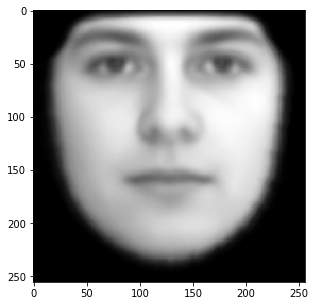

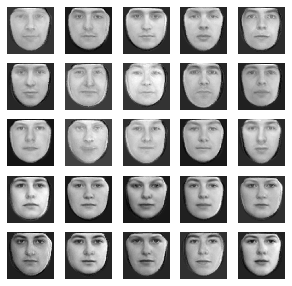

In [215]:
reconstruct(mean_face(train_face_array), subtract_mean, k, V)

In [46]:
test_2[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [88]:
def mean_face(face_array):
    mean = np.mean(face_array,0)
    fig3, axes_array = plt.subplots(1,1)
    fig3.set_size_inches(5,5)
    image_plot = axes_array.imshow(mean, cmap=plt.cm.gray)
    fig3.canvas.set_window_title("mean faces")
    plt.show()
    return mean

In [104]:
test_1 = glob.glob('03_data/face_data/*.bmp')

In [105]:
test_1[1]

'03_data/face_data\\face001.bmp'

In [ ]:
image_1 = Image.open

In [24]:

faces = datasets.fetch_olivetti_faces()
faces.data.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\etern\scikit_learn_data


(400, 4096)

In [49]:
faces

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
         0.1570248 ],
        [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
         0.15289256],
        [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
         0.15289256],
        ...,
        [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
         0.19008264],
        [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
         0.60330576],
        [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
         0.38429752]], dtype=float32),
 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
          0.3305785 , 0.30578512],
         [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
          0.338843  , 0.3140496 ],
         [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
          0.338843  , 0.29752067],
         ...,
         [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
     